[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/HSinger04/ANNwTFHW5/ANNwTFHW5.ipynb)

## Imports

In [34]:
import matplotlib.pyplot as plt
import numpy as np
# TODO: uncomment for colab
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, \
    BatchNormalization, ReLU, ELU, Flatten, Dense

## Define Model

In [36]:
model = Sequential()

# TODO: interpret padding correctly and use it here
def add_conv_to_model(filters, kernel_size=[3,3]):
    """ Convenience function for adding often used sub architectures """
    #raise NotImplementedError("# TODO: interpret padding correctly and use it here")
    model.add(Conv2D(filters=filters, kernel_size=kernel_size))
    # TODO: BN not exactly like in paper - compare later
    model.add(BatchNormalization(momentum=0.05))
    # TODO: Maybe difference compared to paper
    # TODO I can also try implementing a different ReLU
    model.add(ELU())

def add_pool_to_model():
    """ Another convenience function for adding often used sub architectures """
    # TODO: didn't implement everything from paper
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.1))

add_conv_to_model(64)
add_conv_to_model(128)
add_conv_to_model(128)
add_conv_to_model(128)
add_pool_to_model()
add_conv_to_model(128)
add_conv_to_model(128)
add_conv_to_model(128)
add_pool_to_model()
add_conv_to_model(128)
add_conv_to_model(128, kernel_size=[1,1])
add_conv_to_model(128, kernel_size=[1,1])
add_pool_to_model()
add_conv_to_model(128)
add_pool_to_model()

# newest version, but pretty big
"""
add_conv_to_model(64)
add_conv_to_model(128)
add_conv_to_model(128)
add_conv_to_model(128)
add_pool_to_model()
add_conv_to_model(128)
add_conv_to_model(128)
add_conv_to_model(256)
add_pool_to_model()
add_conv_to_model(256)
add_conv_to_model(256)
add_pool_to_model()
add_conv_to_model(512)
add_pool_to_model()
add_conv_to_model(2048, kernel_size=[1, 1])
add_conv_to_model(256, kernel_size=[1, 1])
add_pool_to_model()
add_conv_to_model(256)
"""

# TODO: in the original implementation, maxpool2d appears here
model.add(Flatten())
model.add(Dense(10, activation=tf.keras.activations.softmax))
model.add(Dropout(0.1))

# TODO: assert that model has been correctly built

## Load dataset

In [37]:
train_data, test_data = tfds.load(
    'cifar10', split=['train', 'test'], as_supervised=True)

## Inspect data set

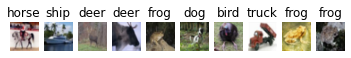

In [38]:
fig, ax = plt.subplots(1,10)
shapes = []

num_to_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
"ship", "truck"]

# TODO: print names instead of numerical labels
for i, (img, lbl) in enumerate(train_data):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(num_to_name[lbl.numpy()])
    ax[i].axis("off")
    shapes.append(img.shape)

## Define some constants

In [39]:
# arbitrarily set. Feel free to change these
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

## Prepare data

In [40]:
def process_inp_and_label(input, label):
    """ rescale inputs and onehotify labels """
    new_input = input / 255
    return new_input, tf.one_hot(label, 10)

def data_pipeline(data):
    """ helper function for data pipeline - does all the things we need """
    data = data.map(process_inp_and_label)
    # arbitrarily set buffer_size - feel free to use sth. else
    data = data.shuffle(buffer_size=BATCH_SIZE)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

train_data = data_pipeline(train_data)
test_data = data_pipeline(test_data)

## Define helper functions

In [41]:
def train_step(model, input, target, loss_function, optimizer):
    accuracy = None

    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy = np.mean(accuracy)

    return loss, accuracy

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

def plot_stats(train_stat, test_stat, stat_name):
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Training steps")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

In [42]:
tf.keras.backend.clear_session()

## Prepare for training

In [43]:
num_epochs = 10
learning_rate = 0.001
# set to 0 if you want to use mean instead of running average
running_average_factor = 0
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# define calc_stat here to access running_average_factor
def calc_stat(stat_so_far, new_stat, stat_num):
    """Calculates appropriate statistic

    :param stat_so_far: the statistic that we have observed so far
    :param new_stat: the newest observed statistic
    :param stat_num: new_stat is the stat_num-th observed statistic
    :return: if 0, return mean, else running average
    """

    if running_average_factor:
        return running_average_factor * stat_so_far + (1 - running_average_factor) * new_stat
    # calculate mean of observed statistics so far
    return ((stat_num - 1) * stat_so_far + new_stat) / stat_num

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

##Train

In [46]:
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch+1))

    # shuffle train data. No need to shuffle test data
    train_data = train_data.shuffle(buffer_size=BATCH_SIZE)

    train_loss_stat = 0
    train_accuracy_stat = 0
    for i, (input, target) in enumerate(train_data):
        train_loss, train_accuracy = train_step(model, input, target, loss, optimizer)
        train_loss_stat = calc_stat(train_loss_stat, train_loss, i+1)
        train_accuracy_stat = calc_stat(train_accuracy_stat, train_accuracy, i+1)
    train_losses.append(train_loss_stat)
    train_accuracies.append(train_accuracy_stat)

    # testing
    test_loss, test_accuracy = test(model, test_data, loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(test_accuracy)

Epoch: 1


InvalidArgumentError: Computed output size would be negative: -2 [input_size: 0, effective_filter_size: 3, stride: 1] [Op:Conv2D]

In [ ]:
##Plot

##Plot

In [ ]:
plot_stats(train_losses, test_losses, "Loss")
plot_stats(train_accuracies, test_accuracies, "Accuracy")

## Assert over 95%

In [ ]:
assert test_accuracies[-1] >= 0.95
print(test_accuracies)